In [11]:
import numpy as np
import torch
import sys
sys.path.append('../../mist-base/GW')
import gw150814_simulator as gs
import jax.numpy as jnp
    
class Simulator_Additive:
    def __init__(self, Nbins, sigma, bounds=5, fraction=None, 
                 sample_fraction=False, bkg=False, device='cpu', 
                 dtype=torch.float64, mode=None, bump = None, pve_bounds =True,
                 specific_theta = None,
                 lock_amp = False, lock_mu=False, lock_sigma=False):
        """
        Args:
        - Nbins (int): Number of bins in the histogram.
        - sigma (float): Standard deviation of the Gaussian noise.
        - bounds (float): Bounds for the uniform distribution of the additive noise.
        - fraction (float): Fraction of bins to be perturbed by the additive noise. If None, just one bin is perturbed.
        - bkg (bool): If True, the simulator generates a bkground signal.
        - device (str): Device to run the tensors on.
        - dtype (torch.dtype): Data type of the tensors.
        - mode (str): white, complex or gw - simulation generation mode
        - bump (str or list): None, det or [a,m,s] - whether to generate a bump as mu and whether it is stochastic or not
        - pve_bounds (bool): If True, 
        """
        self.mode = mode
        if self.mode == 'gw':
            default = gs.defaults
            default['posterior_samples_path'] = '../../mist-base/GW/GW150814_posterior_samples.npz'
            self.gw = gs.GW150814(settings=default)
            # self.Nbins = len(self.gw.time_to_frequency_domain(self.gw.generate_time_domain_waveform())[100:1024])
            self.Nbins = len(self.gw.frequencies)
            self.grid = self.gw.frequencies
            self.psdnorm = torch.tensor(np.sqrt(self.gw.psd))
        else: 
            self.Nbins = Nbins
            self.grid = torch.linspace(0, 100, self.Nbins, device=device, dtype=dtype)
        # print(f'the number of bins is {self.Nbins}')

        self.device = device
        self.dtype = dtype
        self.sigma = sigma
        self.bounds = np.abs(bounds)
        self.bkg = bkg
        self.fraction = fraction
        self.sample_fraction = sample_fraction


        self.bump = bump
        self.pve_bounds = pve_bounds

        self.lock_amp = lock_amp
        self.lock_mu = lock_mu
        self.lock_sigma = lock_sigma

        self.spec_theta = specific_theta

        # print(f'self.Nbins {self.Nbins}')
        # print(f'shape of self.grid {self.grid.shape}')

    def _fd_noise(self,nsims):
        xshape = [nsims, len(self.grid)]
        white_noise_fd = (
            np.random.normal(size=xshape)
            + 1j * np.random.normal(size=xshape)
        ) / np.sqrt(2)
        prefactor = np.sqrt(self.gw.psd) / np.sqrt(2 * self.gw.delta_f)
        noise_fd = prefactor * white_noise_fd
        noise_fd_filtered = noise_fd * self.gw.filter
        return torch.tensor(np.abs(noise_fd))/self.psdnorm
    
    def _fd_waveform(self,nsims):
        xshape = [nsims, len(self.grid)]
        choice = np.random.choice(self.gw.posterior_array.shape[0])
        params = self.gw.posterior_array[choice]
        theta_ripple = jnp.array(
            [
                params[0],
                params[1],
                params[2],
                params[3],
                params[4],
                params[5],
                params[6],
                params[7],
            ]
        )  # M_c, eta = q / (1 + q)^2, s1_z, s2_z, d_L, t_c + epoch, phase_c, iota
        ra, dec, psi = params[8], params[9], params[10]
        hp, hc = self.gw.call_waveform(theta_ripple)
        wf_fd = self.gw.detector.fd_response(
            self.gw.frequencies,
            {"p": hp, "c": hc},
            params={"ra": ra, "dec": dec, "psi": psi, "gmst": self.gw.gmst},
        )
        # wf_fd_filtered = wf_fd*self.gw.filter
        wf_fd_np = np.array(wf_fd)
        wf_fd_block = torch.ones(xshape)*torch.abs(torch.from_numpy(wf_fd_np))
        return wf_fd_block/self.psdnorm

    def _gauss(self, x: torch.Tensor, m, amp, sigma) -> torch.Tensor:
        return amp * np.exp(-0.5 * ((x - m) / sigma) ** 2)
            
    def get_theta(self, Nsims: int) -> torch.Tensor:
        theta_locked = torch.tensor([self.Nbins/2,3,self.Nbins/24])*torch.ones(Nsims, 3)
        if self.bump != 'stoch':
            return theta_locked if self.spec_theta == None else self.spec_theta
        else:
            norm = torch.tensor([self.Nbins/5,1,8])
            start = torch.tensor([self.Nbins/2, 3,self.Nbins/24])
            theta = torch.abs(torch.rand(Nsims, 3, device=self.device, dtype=self.dtype) * norm + start)
            locks = torch.tensor([self.lock_mu, self.lock_amp, self.lock_sigma], device=self.device, dtype=torch.bool)
            output = torch.where(locks, theta_locked, theta)
            return output


    def get_mu(self, theta: torch.Tensor) -> torch.Tensor:
        Nsims = theta.shape[0]
        base = torch.zeros(self.Nbins).unsqueeze(0)
        grid = torch.arange(self.Nbins).unsqueeze(0)*torch.ones([Nsims,self.Nbins])
        mu = self._gauss(grid, theta[:,0].unsqueeze(-1), theta[:,1].unsqueeze(-1), theta[:,2].unsqueeze(-1))
        return mu
    
    def get_x_H0(self, Nsims: int, mu: torch.Tensor = 0) -> torch.Tensor:
        x_shape = (Nsims, self.Nbins)
        if self.mode == 'white':
            noise = (torch.randn(x_shape, device=self.device, dtype=self.dtype) * self.sigma).to(self.dtype)
            return mu + noise
        elif self.mode == 'complex':
            noise = torch.complex(torch.randn(x_shape), torch.randn(x_shape))
            norm_noise = torch.abs(noise).to(self.dtype)
            return mu+norm_noise

    def get_ni(self, x: torch.Tensor) -> torch.Tensor:
        if self.fraction is None:
            """Standard basis vectors"""
            batch_size, N_bins = x.shape
            ni = torch.zeros(batch_size, N_bins, device=self.device, dtype=self.dtype)
            indices = torch.randint(0, N_bins, (batch_size,), device=self.device)
            ni[torch.arange(batch_size), indices] = 1
        else:
            """Fraction of bins are distorted"""
            if self.sample_fraction:
                fr = np.random.uniform(0.01, self.fraction)
            else:   
                fr = self.fraction
            prob = fr
            random_vals = torch.rand_like(x)
            ni = (random_vals < prob).type(self.dtype)  # fr% chance
        return ni
    
    def get_epsilon(self, ni: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        if self.pve_bounds:
            return self.bounds * torch.rand(x.shape, device=self.device, dtype=self.dtype) * ni # returns on [0, self.bounds)
        else:
            return (2 * self.bounds * torch.rand(x.shape, device=self.device, dtype=self.dtype) - self.bounds) * ni # returns on [-self.bounds, self.bounds)
    
    def get_x_Hi(self, epsilon: torch.Tensor, ni: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return x + epsilon * ni
    
    def _sample(self, Nsims: int) -> dict:
        sample = {}
        x_shape = (Nsims, self.Nbins)
        if self.bkg:
            theta = self.get_theta(Nsims)
            mu = self.get_mu(theta)
            sample['theta'] = theta
            sample['mu'] = mu
            x0 = self.get_x_H0(Nsims, mu)
        else:
            mu = torch.zeros(x_shape).to(dtype=self.dtype)
            sample['mu'] = mu.to(dtype=self.dtype)
            x0 = self.get_x_H0(Nsims, 0).to(dtype=self.dtype)
        ni = self.get_ni(x0).to(dtype=self.dtype)
        epsilon = self.get_epsilon(ni, x0).to(dtype=self.dtype)
        xi = self.get_x_Hi(epsilon, ni, x0).to(dtype=self.dtype)
        
        sample.update({'x0': x0,'epsilon': epsilon, 'ni': ni, 'xi': xi})
        return sample
    
    def _resample(self, sample: dict) -> dict:
        Nsims = sample['x0'].shape[0] if sample['x0'].ndim == 2 else 1
        if self.bkg:
            sample['x0'] = self.get_x_H0(Nsims, sample['mu'])
        else:  
            sample['x0'] = self.get_x_H0(Nsims, 0)
        sample['ni'] = self.get_ni(sample['x0'])
        sample['epsilon'] = self.get_epsilon(sample['ni'], sample['x0'])
        sample['xi'] = self.get_x_Hi(sample['epsilon'], sample['ni'], sample['x0'])
        return sample
    
    def sample(self, Nsims: int = 1) -> dict:
        sample = self._sample(Nsims)
        return sample

In [12]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [13]:
simulator = Simulator_Additive(100,1,5,0.2,mode='gw')

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


In [14]:
N_mc = 2e6

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
data_bin_H0 = []

for _ in tqdm(range(N_batch)):
    dummy = np.ones([124,len(simulator.grid)])*simulator.grid
    mc_samples = simulator._fd_noise(124)
    data_bin_H0.append(mc_samples)
    
data_bin_H0 = np.concatenate(data_bin_H0)


### Start by ascertaining the data distribution ###
from scipy.stats import norm
def get_quantiles(indata, nsig:int, sigma_key=False):
    data = np.sort(indata)
    sigmas = np.arange(-nsig,nsig+1,1)
    indices = (len(data)*norm.cdf(sigmas)).astype(int)
    if not sigma_key:
        return data[indices]
    else:
        return np.array([data[indices],sigmas])
    
alldata = data_bin_H0.flatten()
mean = np.mean(alldata)
quantiles = get_quantiles(alldata, 3)
quantiles_long = get_quantiles(alldata,5)

100%|██████████| 488/488 [00:15<00:00, 32.51it/s]


True

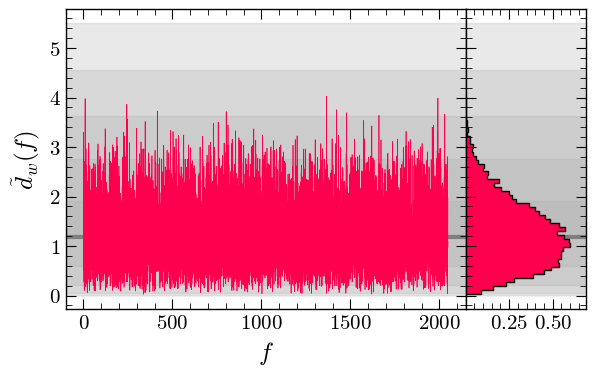

In [15]:
dummy = np.ones([124,len(simulator.grid)])*simulator.grid
a = simulator._fd_noise(124)
b = simulator._fd_waveform(124)

fig,ax = pf.create_plot()
ax2 = fig.add_axes((1,0,0.3,1))
plt.setp(ax2.get_yticklabels(), visible=False)

ax.plot(simulator.grid,a[0], color='#ff004f', lw=0.5, alpha=1)

ax.set_ylabel(r'$\tilde{d}_w(f)$')
ax.set_xlabel(r'$f$')
ax.set_xlim(-100, 2148)

ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='#ff004f')
ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='black', histtype='step')
ax2.set_xticks([0.25,0.50])
ax2.set_xlim([0,0.69])

for i,q in enumerate(quantiles_long):
    extra = np.linspace(-100,2148, 100)
    ax.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)
    ax2.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)

ax.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)
ax2.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)


pf.fix_plot([ax,ax2])